In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [132]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
class LabelEncoder(BaseEstimator, TransformerMixin):
    """Label encoding для категориальных данных, каждой категории присваивается значение от 0 до N-1
    (здесь N - количество категорий для признака)
    
    Параметры
    ----------
    
    cols: list
        список названий колонок, которые необходимо преобразовать
    drop_invariant: bool
        логическое значение, отбрасывать ли столбцы с нулевой дисперсией
        
    """
    def __init__(self, cols=None, drop_invariant=False):
        self.cols = cols
        self.drop_invariant = drop_invariant
        
    def fit(self, X, y=None):
        if self.drop_invariant:
            self.drop = []
            for i in self.cols:
                if len(X[i].unique()) == 1:
                    self.drop.append(i)
            for i in self.drop:
                self.cols.remove(i)
        self.le = []
        for i in self.cols:
            self.le.append(preprocessing.LabelEncoder().fit(X[i]))
        return self   
        
    def transform(self, X):
        if self.drop_invariant:
            X = X.drop(self.drop, axis=1)
        
        for i, j in zip(self.cols, self.le):
            X.loc[:, i+'_le'] = j.transform(X[i])
        X = X.drop(self.cols, axis=1)
        
        return X
    
    def get_feature_names(self):
        return [(i+'_le') for i in self.cols]

In [5]:
trans = LabelEncoder(cols=columns)
train = trans.fit_transform(train)

In [6]:
y = train['target']
train.drop(columns=['target'], inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=42)

In [25]:
model = KNeighborsRegressor(n_neighbors=10, metric='hamming')

In [31]:
d = defaultdict(float)
for i in tqdm(range(4, 170)):
    model = KNeighborsRegressor(n_neighbors=i, metric='hamming')
    model.fit(X_train, y_train)
    d[i] = roc_auc_score(y_test, model.predict(X_test))

In [111]:
a = {k: v for k, v in sorted(d.items(), key=lambda item: item[0])}

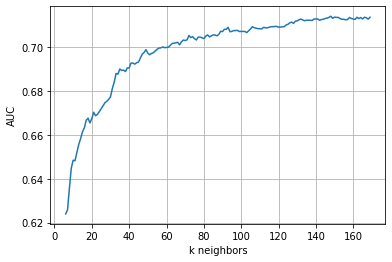

In [119]:
plt.grid()
plt.ylabel('AUC')
plt.xlabel('k neighbors')
plt.plot(list(a.keys()), list(a.values()))
plt.savefig('baseline.pdf')

In [135]:
y = train['target']
train.drop(columns=['target'], inplace=True)

In [137]:
trans = LabelEncoder(cols=columns)
trans.fit(pd.concat([train, test]))
train = trans.transform(train)
test = trans.transform(test)

In [139]:
model = KNeighborsRegressor(n_neighbors=150, metric='hamming')
model.fit(train, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='hamming',
                    metric_params=None, n_jobs=None, n_neighbors=150, p=2,
                    weights='uniform')

In [140]:
%%time
preds = model.predict(test)

CPU times: user 50min 52s, sys: 9.65 s, total: 51min 2s
Wall time: 51min 33s


In [147]:
sample_submission = pd.read_csv('/Users/ama/Desktop/cat-in-the-dat/sample_submission.csv', index_col=0)

In [148]:
sample_submission['target'] = preds

In [149]:
sample_submission.to_csv('baseline.csv')

In [ ]:
#0.71753